In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [177]:
'''
LightGBM module

the module can be use for both classification and regression problem the appropriate objective method should be defined.
more information can be find here
https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters.rst
http://lightgbm.readthedocs.io/en/latest/Python-API.html

AT THE MOMENT
User can NOT define a customized objective function and evaluation function

optimization with grid search is easy first make a grid

make_grid(learning_rate = [1, 2, 3], max_depth = [3, 4, 5])

then run the optimization
optimization(self, X, y, X_test, y_test, verbose_eval = False, num_boost_round = None, early_stopping = 2)

to see the result and select best parameters
scores()


get the importance features and plot them is another awesome part of this module :)

get_importance()
plot_importance()

comparision of XGB and LGB
https://sites.google.com/view/lauraepp/parameters

used skopt module for bayesian optimization

'''
import lightgbm as lgb
import pandas as pd
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm

color = sns.color_palette()

class LGB(object):
    def __init__(self, num_boost_round=10, objective=None, metric='None', feval=None, fobj=None, **kwargs):
        self.clf = None
        self.grid_params = None
        self.result = None
        self.grid_list = []
        self.feval = feval
        self.fobj = fobj
        self.num_boost_round = num_boost_round
        self.params = kwargs
        if not fobj:
            if objective:
                print("Built a LightGBM with defiend objective function")
                self.params.update({'boosting_type': 'gbdt', 'objective' : objective, 'metric' : metric})               
            else:
                print("Built a LightGBM with default objective")
                self.params.update({'boosting_type': 'gbdt', 'objective' : 'regression_l2', 'metric' : 'l1'})
            
        print(self.params)
        
    def set_params(self, print_out=True, **params):
        if 'num_boost_round' in params:
            self.num_boost_round = params.pop('num_boost_round')
        self.params.update(params)
        if print_out:
            print(self.params)
            
    def set_params_scores(self, dt, N=1):
        print(self.params)
        params = dt.iloc[N].to_dict()
        if 'score' in params:
            del params['score']
        if 'iterations' in params:
            self.num_boost_round = params.pop('iterations')
        self.params.update(params)
        print(self.params)
        
    def set_params_dic(self, dic):
        if 'num_boost_round' in dic:
            self.num_boost_round = dic.pop('num_boost_round')
        self.params.update(dic)
        print(self.params)
        
    def fit(self, X, y, num_boost_round=None, categorical=None):
        num_boost_round = num_boost_round or self.num_boost_round
        dtrain = lgb.Dataset(X, label=y, categorical_feature=categorical)
        self.clf = lgb.train(params=self.params, train_set=dtrain, num_boost_round=num_boost_round)
        
    def predict(self, X):
        return self.clf.predict(X)
    
    def get_params(self, deep=True):
        return self.params

    def get_importance(self):
        importance = {}
        for key, val in zip(self.clf.feature_name(), self.clf.feature_importance()):
            importance[key] = val
        return importance

    def plot_importance(self, N = 10):
        importance = {}
        for key, val in zip(self.clf.feature_name(), self.clf.feature_importance()):
            importance[key] = val

        import operator
        importance = sorted(importance.items(), key=operator.itemgetter(1))

        importance_df = pd.DataFrame(importance, columns=['feature', 'fscore'])
        importance_df['fscore'] = importance_df['fscore'] / importance_df['fscore'].sum()

        plt.figure()
        importance_df[-N:].plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(10, 5))
        plt.title('XGBoost Feature Importance')
        plt.xlabel('relative importance')
        plt.ylabel('')
        plt.show()
    
    def fit_eval(self, X, y, X_test, y_test, verbose_eval = False, num_boost_round = None, early_stopping = 5,
                 categorical=None, train_score=False, Min=True, print_out=False):
        num_boost_round = num_boost_round or self.num_boost_round
        dtrain = lgb.Dataset(X, label=y, categorical_feature=categorical)
        dtest = lgb.Dataset(X_test, y_test, categorical_feature=categorical, reference=dtrain)
        
        valid_list = [[dtest], ['valid']]
        if train_score:
            valid_list[0].append(dtrain)
            valid_list[1].append('train')
        
        if self.feval == None:
            self.clf = lgb.train(params = self.params, train_set = dtrain, num_boost_round = num_boost_round,
                             valid_sets = valid_list[0], valid_names = valid_list[1],
                             verbose_eval = verbose_eval,
                             early_stopping_rounds = early_stopping)
        else:
            print(" Later :)")
#             self.params.update({'metric': 'None'})
#             self.clf = lgb.train(params = self.params, train_set = dtrain, num_boost_round = num_boost_round,
#                              valid_sets = [dtrain, dtest], valid_names = ['train', 'valid'],
#                              verbose_eval = verbose_eval,
# #                             feval = self.evalerror, 
#                              early_stopping_rounds = early_stopping)

        if print_out:
            print("Number of iteration: ", self.clf.best_iteration, " Score: ", self.clf.best_score['valid'])
            return
        else:
            if Min:
                return self.clf.best_score['valid'][list(self.clf.best_score['valid'].keys())[0]]
            else:
                return -self.clf.best_score['valid'][list(self.clf.best_score['valid'].keys())[0]]
        
    def fit_cv(self, X, y, cv, verbose_eval = False, num_boost_round = None, early_stopping = 5,
                 categorical=None, print_out=False, Min=True):
        
        num_boost_round = num_boost_round or self.num_boost_round
        scores = []
        for i, (train_index, test_index) in enumerate(cv.split(X, y)):
            dtrain = lgb.Dataset(X[train_index], label=y[train_index], categorical_feature=categorical)
            dtest = lgb.Dataset(X[test_index], label=y[test_index], categorical_feature=categorical, reference=dtrain)

            if self.feval == None:
                self.clf = lgb.train(params = self.params, train_set = dtrain, num_boost_round = num_boost_round,
                             valid_sets = [dtrain, dtest], valid_names = ['train', 'valid'],
                             verbose_eval = verbose_eval,
                             early_stopping_rounds = early_stopping)
            else:
                print(" Later :)")
#                 self.params.update({'metric': 'None'})
#                 self.clf = lgb.train(params = self.params, train_set = dtrain, num_boost_round = num_boost_round,
#                              valid_sets = [dtrain, dtest], valid_names = ['train', 'valid'],
#                              verbose_eval = verbose_eval,
# #                             feval = self.evalerror, 
#                              early_stopping_rounds = early_stopping)
            
            scores.append(self.clf.best_score['valid'][list(self.clf.best_score['valid'].keys())[0]])
            
            if print_out:
                print("Kfold: ", i, "Number of iteration: ", self.clf.best_iteration, " Score: ", self.clf.best_score['valid'])

        if not print_out:
            if Min:
                return np.mean(scores)
            else:
                return -np.mean(scores)

        
    def grid(self, keys, comb, it=0):
        if len(keys) == it:
            return

        for x in self.grid_params[keys[it]]:
            comb.append(x)
            self.grid(keys, comb, it+1)
            if len(comb) == len(keys):
                self.grid_list.append(comb[:])
            comb.pop()
    
    def make_grid(self, **kwargs):
        self.grid_list = []
        self.grid_params = kwargs
        print(self.params)
        print(self.grid_params)
        self.grid(list(self.grid_params.keys()), [])
        print("Number of iteration for Optimization: ", len(self.grid_list))
        
    def optimization(self, X, y, X_test, y_test, verbose_eval = False, num_boost_round = None, early_stopping = 2,
                     categorical=None):
        
        if categorical:
            print("Used categorical features: ", categorical)
            warnings.filterwarnings("ignore")
            
        num_boost_round = num_boost_round or self.num_boost_round
        
        dtrain = lgb.Dataset(X, label=y, categorical_feature=categorical, free_raw_data=False)
        dtest = lgb.Dataset(X_test, y_test, categorical_feature=categorical, reference=dtrain, free_raw_data=False)

        col = list(self.grid_params.keys()) + ['iterations', 'score']
        self.result = pd.DataFrame(columns=col)

        for i in tqdm(range(len(self.grid_list))):
            temp = self.params
            for j, key in enumerate(self.grid_params.keys()):
                temp[key] = self.grid_list[i][j]

            if self.feval == None:
                self.clf = lgb.train(params = temp, train_set = dtrain, num_boost_round = num_boost_round,
                                 valid_sets = [dtest], valid_names = ['valid'],
                                 verbose_eval = False,
                                 early_stopping_rounds = early_stopping)
            else:
                print(" Later :)")
#                 self.params.update({'metric': 'None'})
#                 self.clf = lgb.train(params = temp, train_set = dtrain, num_boost_round = num_boost_round,
#                                  valid_sets = [dtrain, dtest], valid_names = ['train', 'valid'],
#                                  verbose_eval = False,
#     #                             feval = self.evalerror, 
#                                  early_stopping_rounds = early_stopping)
            
            score = self.clf.best_score['valid'][list(self.clf.best_score['valid'].keys())[0]]
            self.result = self.result.append(pd.DataFrame([self.grid_list[i] + [self.clf.best_iteration, score]], columns=col))
    
    def scores(self, N=4, Min=True):
        return self.result.sort_values("score", ascending=Min)[:N]
    
    def bayesian(self, X, y, X_test=None, y_test=None, cv=None, early_stopping = 5, ncalls = 10, seed=0,
                 num_boost_round=None, warrning=False, Min=True, **kwargs):
        
        num_boost_round = num_boost_round or self.num_boost_round
        
        if not warrning:
            print("Ignore UserWarning")
            warnings.filterwarnings("ignore")
        if cv:
            print("CV optimization")
        print(kwargs)
        space = []
        for key, val in kwargs.items():
            if key == "learning_rate":
                space.append(Real(val[0], val[1], "log-uniform", name='learning_rate'))
            elif key == "num_leaves":
                space.append(Integer(val[0], val[1], name='num_leaves'))
            elif key == 'subsample': 
                space.append(Real(val[0], val[1], "uniform", name='subsample'))
            elif key == 'colsample_bytree': 
                space.append(Real(val[0], val[1], "uniform", name='colsample_bytree'))
            elif key == "reg_lambda":
                space.append(Real(val[0], val[1], "uniform", name='reg_lambda'))
            elif key == "reg_alpha":
                space.append(Real(val[0], val[1], "uniform", name='reg_alpha'))
            elif key == "min_split_gain":
                space.append(Real(val[0], val[1], "uniform", name='min_split_gain'))
            elif key == "min_child_samples":
                space.append(Integer(val[0], val[1], name='min_child_samples'))
            elif key == "scale_pos_weight":
                space.append(Integer(val[0], val[1], name='scale_pos_weight'))
            else:
                print("Error: Invalid parameter", key)
        
        print(space)
                
                
        @use_named_args(space)
        def objective(**params):
            self.set_params(print_out=False, **params)
            
            if cv:
                return self.fit_cv(X, y, cv, verbose_eval = False, num_boost_round = num_boost_round, 
                                 early_stopping = early_stopping, Min=Min)
            else:
                return self.fit_eval(X, y, X_test, y_test, verbose_eval = False, num_boost_round = num_boost_round, 
                                 early_stopping = early_stopping, Min=Min)
        

        res_gp = gp_minimize(objective, space, n_calls = ncalls, random_state=seed)
    
        plot_convergence(res_gp)
        
        col = list(kwargs.keys()) + ['score']
        self.result = pd.DataFrame(columns=col)
        
        for val, score in zip(res_gp.x_iters, res_gp.func_vals):
            self.result = self.result.append(pd.DataFrame([val + [score]], columns=col))

# Create data set

In [163]:
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification

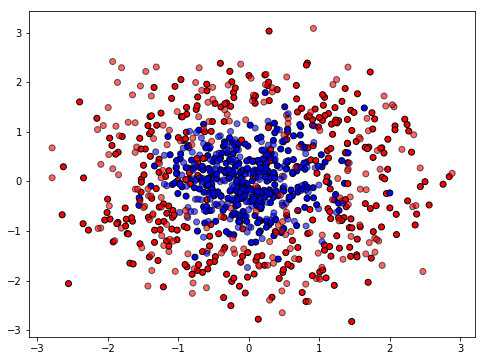

In [164]:
X, y = make_circles(n_samples=1000, shuffle=True, noise=.3, random_state=1, factor=0.2)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

X = StandardScaler().fit_transform(X)
X, X1, y, y1 = train_test_split(X, y, test_size=.4, random_state=42)

# just plot the dataset first
figure = plt.figure(figsize=(8, 6))
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
#ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, edgecolors='k')
# and testing points
plt.scatter(X1[:, 0], X1[:, 1], c=y1, cmap=cm_bright, alpha=0.6, edgecolors='k')

# simple fit

In [178]:
clf = LGB(objective='binary', metric='binary')

Built a LightGBM with defiend objective function
{'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'binary'}


In [166]:
clf.fit(X, y, num_boost_round=50)

In [167]:
y_pred = clf.predict(X1)

In [168]:
from sklearn.metrics import log_loss
log_loss(y1, y_pred)

0.37889487303662889

In [169]:
from sklearn.metrics import average_precision_score
average_precision_score(y1, y_pred) 

0.89893211364276182

# early stop

In [170]:
clf.fit_eval(X, y, X1, y1, num_boost_round=100, verbose_eval=5, early_stopping=5)

Training until validation scores don't improve for 5 rounds.
[5]	valid's binary_logloss: 0.488947
[10]	valid's binary_logloss: 0.403921
[15]	valid's binary_logloss: 0.367231
[20]	valid's binary_logloss: 0.348621
[25]	valid's binary_logloss: 0.344623
Early stopping, best iteration is:
[24]	valid's binary_logloss: 0.343787


0.34378706918721041

In [171]:
y_pred = clf.predict(X1)
log_loss(y1, y_pred)

0.34378706918721036

In [172]:
average_precision_score(y1, y_pred) 

0.90634240140961864

# Grid Search

In [179]:
params = {
    'learning_rate': 0.05,
    'num_leaves': 6,  # we should let it be smaller than 2^(max_depth)
    'max_depth': -1,  # -1 means no limit
    'min_child_samples': 20,  # Minimum number of data need in a child(min_data_in_leaf)
    'max_bin': 255,  # Number of bucketed bin for feature values
    'subsample': 0.9,  # Subsample ratio of the training instance.
    'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
    'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
    'min_child_weight': 5,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
    'subsample_for_bin': 200000,  # Number of samples for constructing bin
    'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
    'reg_alpha': 0,  # L1 regularization term on weights
    'reg_lambda': 0,  # L2 regularization term on weights
    'scale_pos_weight': 1}

In [180]:
clf.set_params_dic(params)

{'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'binary', 'learning_rate': 0.05, 'num_leaves': 6, 'max_depth': -1, 'min_child_samples': 20, 'max_bin': 255, 'subsample': 0.9, 'subsample_freq': 1, 'colsample_bytree': 0.9, 'min_child_weight': 5, 'subsample_for_bin': 200000, 'min_split_gain': 0, 'reg_alpha': 0, 'reg_lambda': 0, 'scale_pos_weight': 1}


In [175]:
clf.make_grid(learning_rate = [0.01, 0.05, 0.1], num_leaves = [5, 10, 15, 20])

{'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'binary', 'verbose': 1, 'learning_rate': 0.05, 'num_leaves': 6, 'max_depth': -1, 'min_child_samples': 20, 'max_bin': 255, 'subsample': 0.9, 'subsample_freq': 1, 'colsample_bytree': 0.9, 'min_child_weight': 5, 'subsample_for_bin': 200000, 'min_split_gain': 0, 'reg_alpha': 0, 'reg_lambda': 0, 'scale_pos_weight': 1}
{'learning_rate': [0.01, 0.05, 0.1], 'num_leaves': [5, 10, 15, 20]}
Number of iteration for Optimization:  12


In [128]:
clf.optimization(X, y, X1, y1, num_boost_round=500, early_stopping=5)

100%|██████████| 12/12 [00:07<00:00,  1.65it/s]


In [129]:
clf.scores()

,learning_rate,num_leaves,iterations,score
0,0.05,5,113,0.318105
0,0.10,5,61,0.318461
0,0.05,10,112,0.322908
0,0.10,10,56,0.323033


In [130]:
clf.set_params_scores(clf.scores(), N=0)

{'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'binary', 'verbose': 1, 'learning_rate': 0.1, 'num_leaves': 20, 'max_depth': -1, 'min_child_samples': 20, 'max_bin': 255, 'subsample': 0.9, 'subsample_freq': 1, 'colsample_bytree': 0.9, 'min_child_weight': 5, 'subsample_for_bin': 200000, 'min_split_gain': 0, 'reg_alpha': 0, 'reg_lambda': 0, 'scale_pos_weight': 1}
{'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'binary', 'verbose': 1, 'learning_rate': 0.050000000000000003, 'num_leaves': 5, 'max_depth': -1, 'min_child_samples': 20, 'max_bin': 255, 'subsample': 0.9, 'subsample_freq': 1, 'colsample_bytree': 0.9, 'min_child_weight': 5, 'subsample_for_bin': 200000, 'min_split_gain': 0, 'reg_alpha': 0, 'reg_lambda': 0, 'scale_pos_weight': 1}


In [131]:
clf.fit(X, y)

In [132]:
y_pred = clf.predict(X1)

log_loss(y1, y_pred)

0.31810476010209421

# Bayesin

Ignore UserWarning
{'learning_rate': [0.01, 0.1], 'num_leaves': [4, 20]}
[Real(low=0.01, high=0.1, prior='log-uniform', transform='identity'), Integer(low=4, high=20)]


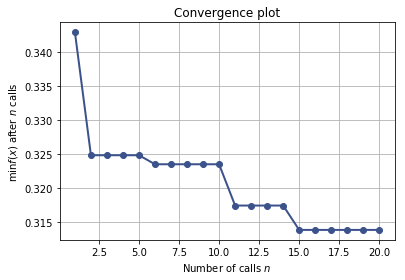

In [183]:
clf.bayesian(X, y, X1, y1, ncalls=20, num_boost_round=100, learning_rate = [0.01, 0.1], num_leaves = [4, 20])

In [184]:
clf.scores()

,learning_rate,num_leaves,score
0,0.082947,4,0.313853
0,0.081517,4,0.314769
0,0.063826,4,0.315895
0,0.070337,4,0.316663


# maximize auc
to maximize a metric set Min=False and the Bayesin model will calculate the negative value of the error

In [186]:
clf = LGB(objective='binary', metric='auc')

Built a LightGBM with defiend objective function
{'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc'}


In [187]:
clf.fit_eval(X, y, X1, y1, num_boost_round=100, verbose_eval=5, early_stopping=5)

Training until validation scores don't improve for 5 rounds.
[5]	valid's auc: 0.911545
[10]	valid's auc: 0.912546
[15]	valid's auc: 0.918064
[20]	valid's auc: 0.921842
[25]	valid's auc: 0.922067
Early stopping, best iteration is:
[21]	valid's auc: 0.922668


0.92266790111099994

Ignore UserWarning
{'learning_rate': [0.01, 0.1], 'num_leaves': [4, 20]}
[Real(low=0.01, high=0.1, prior='log-uniform', transform='identity'), Integer(low=4, high=20)]


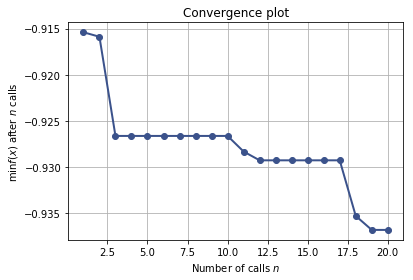

In [188]:
clf.bayesian(X, y, X1, y1, ncalls=20, num_boost_round=100, Min=False, learning_rate = [0.01, 0.1], num_leaves = [4, 20])

In [189]:
clf.scores()

,learning_rate,num_leaves,score
0,0.058115,4,-0.936793
0,0.100000,4,-0.935279
0,0.100000,10,-0.929261
0,0.100000,10,-0.929261
